# Simple image classification with Inception

https://www.tensorflow.org/tutorials/images/image_recognition

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

In [11]:
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
#DATA_URL = 'inception-2015-12-05.tgz'

In [12]:
def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = "."
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [13]:
maybe_download_and_extract()
image = 'cropped_panda.jpg'
model_dir="."
num_top_predictions=5

In [14]:
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""
  def __init__(self, label_lookup_path=None, uid_lookup_path=None):
    label_lookup_path = os.path.join(model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    uid_lookup_path = os.path.join(model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.
    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.
    Returns:
      dict from integer node ID to human-readable string.
    """
    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

In [15]:
def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [16]:
def run_inference_on_image(image):
  #Runs inference on an image.
  image_data = tf.gfile.FastGFile(image, 'rb').read()
  create_graph()
  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across 1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048 float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)
    # Creates node ID --> English string lookup.
    node_lookup = NodeLookup()
    top_k = predictions.argsort()[-num_top_predictions:][::-1]
    for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      score = predictions[node_id]
      print('%s (score = %.5f)' % (human_string, score))

Instructions for updating:
Use tf.gfile.GFile.
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.89107)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.00779)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00296)
custard apple (score = 0.00147)
earthstar (score = 0.00117)


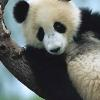

In [8]:
image = 'cropped_panda.jpg'
run_inference_on_image(image)
from IPython.display import Image
Image("cropped_panda.jpg")

hand-held computer, hand-held microcomputer (score = 0.44550)
cellular telephone, cellular phone, cellphone, cell, mobile phone (score = 0.16715)
iPod (score = 0.15218)
remote control, remote (score = 0.00479)
radio, wireless (score = 0.00395)


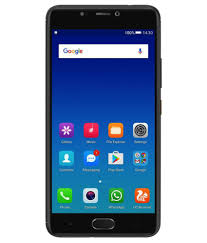

In [24]:
image = 'mobile.jpg'
run_inference_on_image(image)
Image("mobile.jpg")

alp (score = 0.85628)
valley, vale (score = 0.00620)
volcano (score = 0.00568)
cliff, drop, drop-off (score = 0.00354)
ski (score = 0.00206)


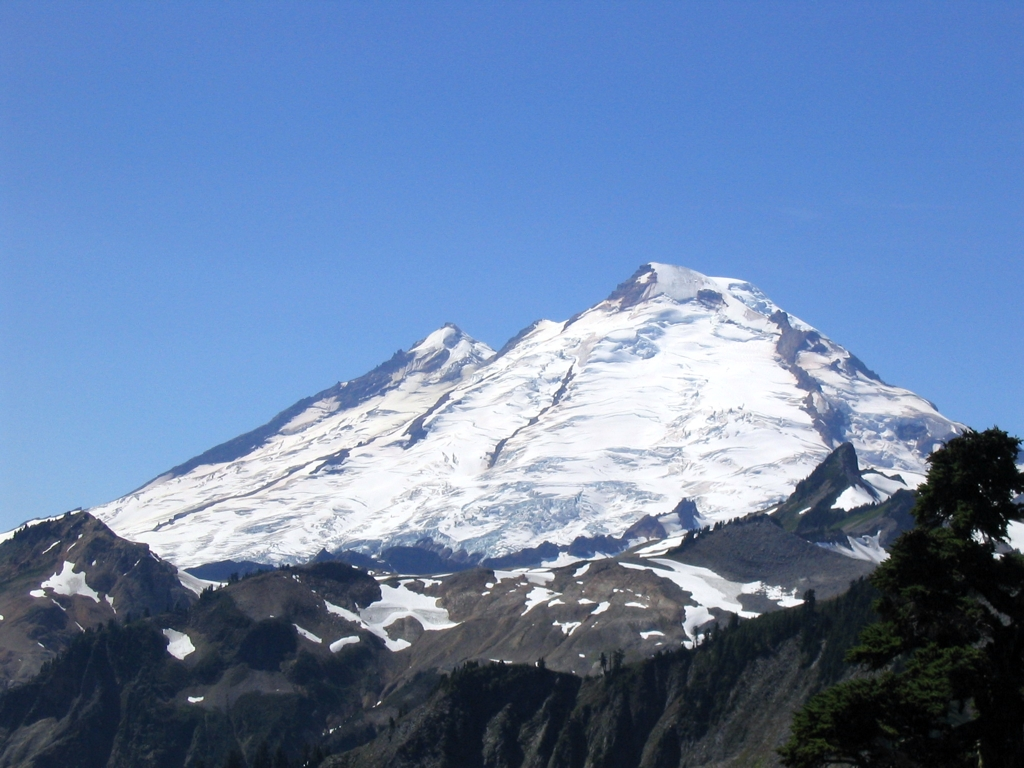

In [25]:
image = 'MtBaker.jpg'
run_inference_on_image(image)
Image(image)

groom, bridegroom (score = 0.53669)
suit, suit of clothes (score = 0.23082)
Windsor tie (score = 0.06913)
bow tie, bow-tie, bowtie (score = 0.01308)
notebook, notebook computer (score = 0.00645)


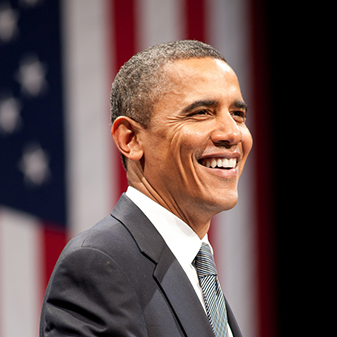

In [26]:
image = 'obama.jpg'
run_inference_on_image(image)
Image(image)

seashore, coast, seacoast, sea-coast (score = 0.69220)
beacon, lighthouse, beacon light, pharos (score = 0.10132)
breakwater, groin, groyne, mole, bulwark, seawall, jetty (score = 0.09127)
promontory, headland, head, foreland (score = 0.05036)
lakeside, lakeshore (score = 0.00790)


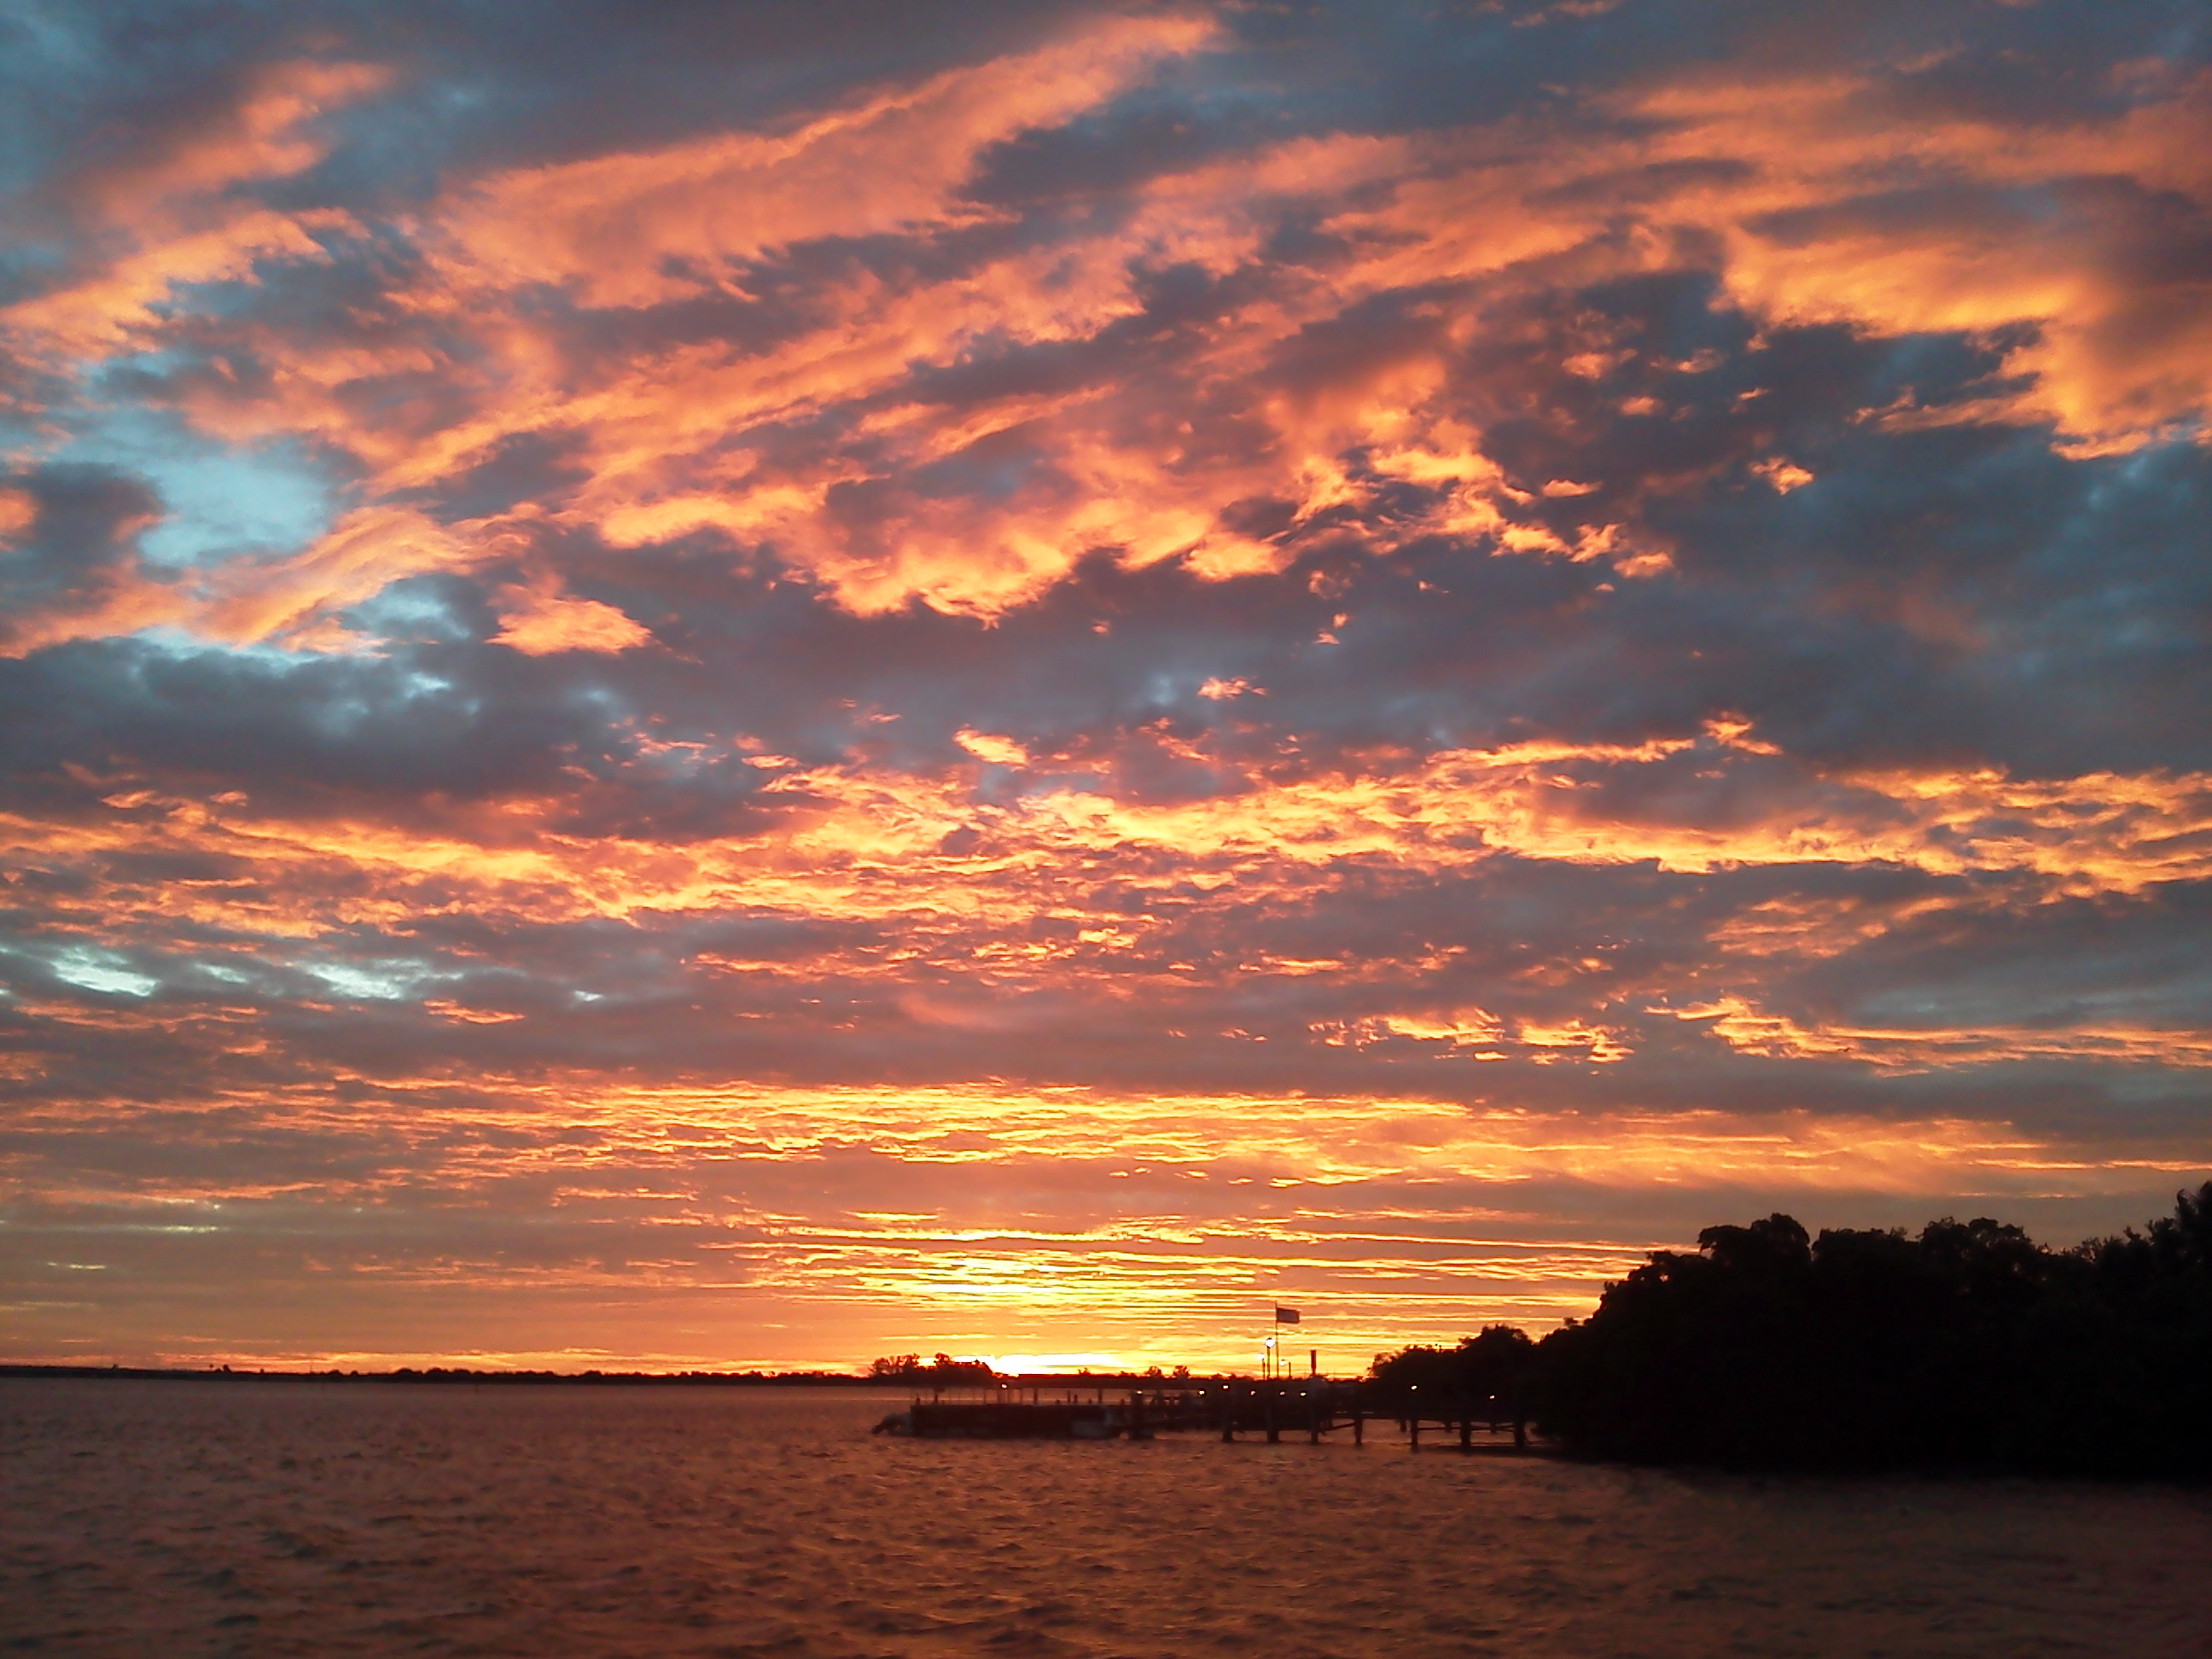

In [27]:
image = 'sunrise.jpg'
run_inference_on_image(image)
Image(image)

lipstick, lip rouge (score = 0.82022)
wig (score = 0.02885)
mask (score = 0.01173)
abaya (score = 0.00364)
red wine (score = 0.00332)


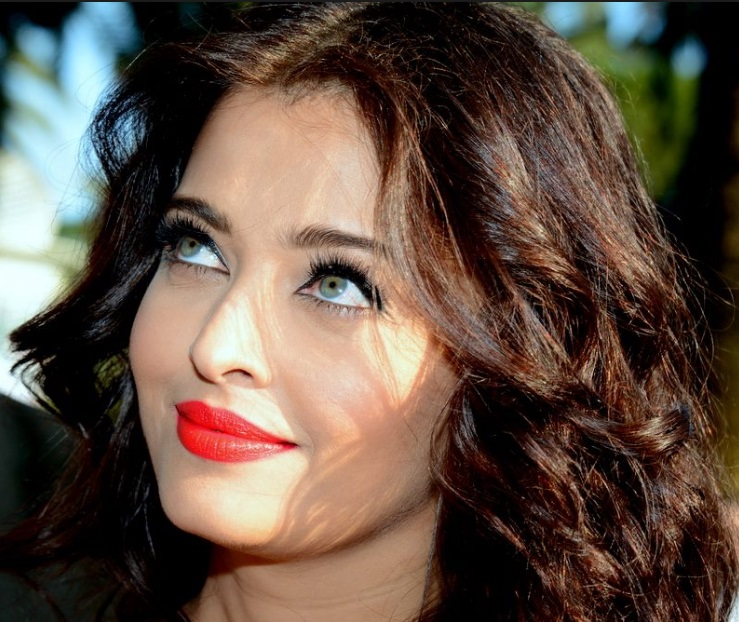

In [28]:
image = 'ash.jpg'
run_inference_on_image(image)
Image(image)

bullfrog, Rana catesbeiana (score = 0.34000)
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui (score = 0.32750)
tree frog, tree-frog (score = 0.10062)
African chameleon, Chamaeleo chamaeleon (score = 0.01774)
triceratops (score = 0.00391)


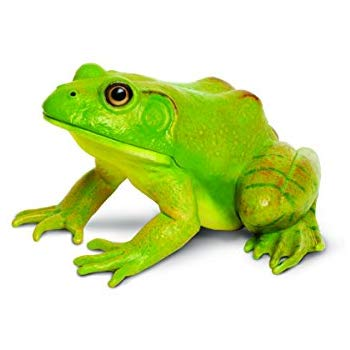

In [29]:
image = 'frog.jpg'
run_inference_on_image(image)
Image(image)

cinema, movie theater, movie theatre, movie house, picture palace (score = 0.30040)
library (score = 0.21101)
planetarium (score = 0.17425)
sundial (score = 0.09347)
flagpole, flagstaff (score = 0.01565)


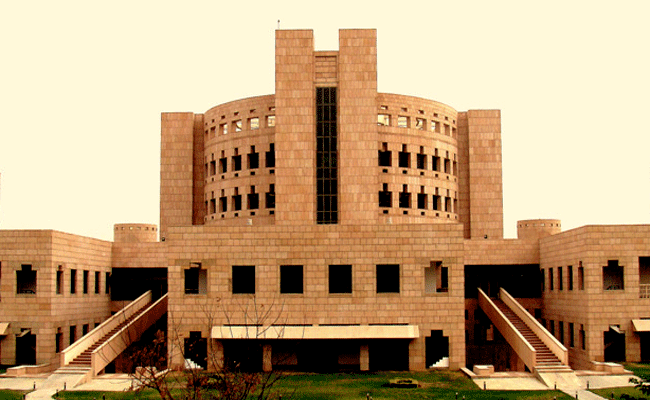

In [30]:
image = 'isb.jpg'
run_inference_on_image(image)
Image(image)